<img src="Project Description.PNG" alt="Drawing" style="width: 800px;"/>

In [3]:
%pip install yfinance

In [4]:
import pandas as pd
import numpy as np
import random
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


size = 18
params = {'legend.fontsize': 'large',
          'figure.figsize': (15,8),
          'axes.labelsize': size * 0.8,
          'axes.titlesize': size * 0.95,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

### The GBM Model for STOXX50E simulation

[*********************100%***********************]  1 of 1 completed


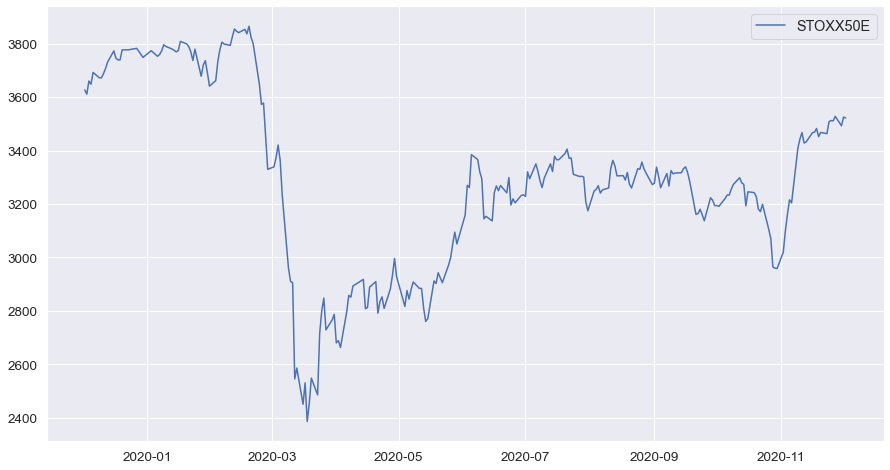

In [5]:
price = yf.download("^STOXX50E", start = "2019-12-01", end = "2020-12-3")['Adj Close'].reset_index()

plt.plot(price['Date'], price['Adj Close'], label = "STOXX50E")
plt.legend()
plt.show()


### Maximum Likelihood Estimator for Drift and Volatility of STOXX50E

In [6]:
n = len(price['Date'])
delta = 1
x_bar = np.sum(np.log(price['Adj Close']/price['Adj Close'].shift(1)))/n

print ("MLE for Drift parameter(μ) : " + str(x_bar))

MLE for Drift parameter(μ) : -0.0001169688553969635


In [7]:
price_bar = np.log(price['Adj Close']/price['Adj Close'].shift(1)) - x_bar
vol = np.sum(np.power(price_bar, 2))/n
vol = np.sqrt(vol)
print ("MLE for Volatility parameter(σ) : " + str(vol))

MLE for Volatility parameter(σ) : 0.020456189051262293


### Simulating Geometric Brownian Motion

90


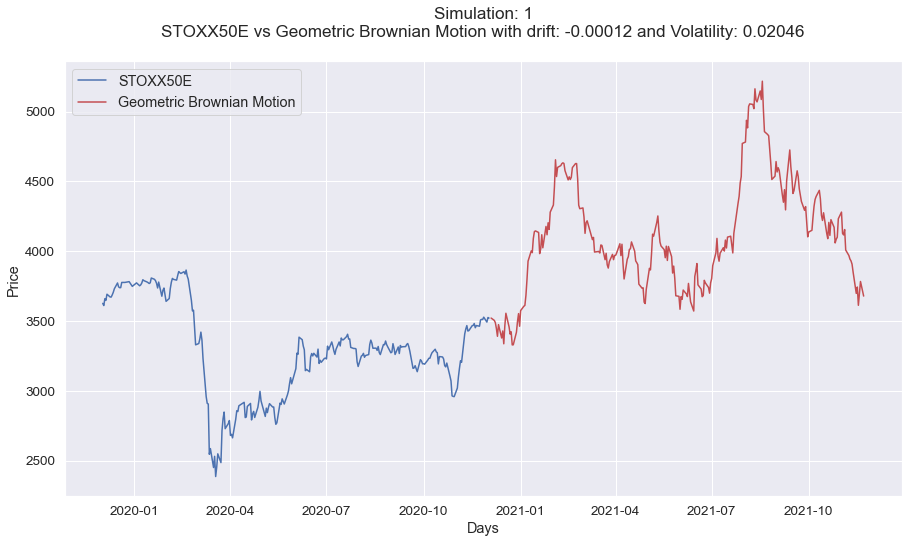

In [8]:
def Brownian(seed, N):
    
    np.random.seed(seed)                         
    dt = 1                                    # time step
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  # brownian increments
    W = np.cumsum(b)                             # brownian path
    return W, b

seed =10
N  = n     # increments

seed_list = [90]
k = 1
for seed in seed_list:
    
    #print ("Simulation: " + str(k))
    print (seed)
    k += 1
    W = Brownian(seed, N)[0]
    W = np.insert(W, 0, 0.)  

    def GBM(So, mu, sigma, W, T, N):    
        t = np.ones((N + 1))
        S = []
        S.append(So)
        for i in range(1,int(N+1)):
            
            #drift = (mu - 0.5 * sigma**2) * t[i]
            drift = (mu) * t[i]
            diffusion = sigma * W[i-1]
            S_temp = So*np.exp(drift + diffusion)
            S.append(S_temp)
        return S, t

    So = price['Adj Close'].iloc[-1]
    mu = x_bar
    sigma = vol
    #pranav
    # mu = 0.2646
    # sigma = 0.247
    W = Brownian(seed, N)[0]
    T = 1.

    GBM_avg = np.zeros((1000, 252))

    for i in range(1000):
        soln = GBM(So, mu, sigma, W, T, N)[0]    # Exact solution
        soln = soln[:-1]
        GBM_avg[i] = soln
    gbm_avg = GBM_avg.mean(axis = 0)
    t = GBM(So, mu, sigma, W, T, N)[1]       # time increments for  plotting
    
    rng = pd.date_range('2020-12-4', periods=len(gbm_avg), freq='B')
    price_gbm = pd.DataFrame({ 'Date': rng, 'Close': gbm_avg}) 

    plt.title('Simulation: ' + str(k- 1) + '\nSTOXX50E vs Geometric Brownian Motion with drift: ' + str(round(mu, 5)) + " and Volatility: " + str(round(sigma, 5)))
    plt.plot(price['Date'], price['Adj Close'], label = "STOXX50E")
    plt.plot(price_gbm['Date'], price_gbm['Close'], color = 'r', label = "Geometric Brownian Motion")
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## The Vasicek Model for USD LIBOR rate simulation
dr(t) = k[θ − r(t)]dt + σdW(t)

In [31]:
def vasicek(r0, K, theta, sigma, T=1., N=252, seed=777):    
    
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + sigma*np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

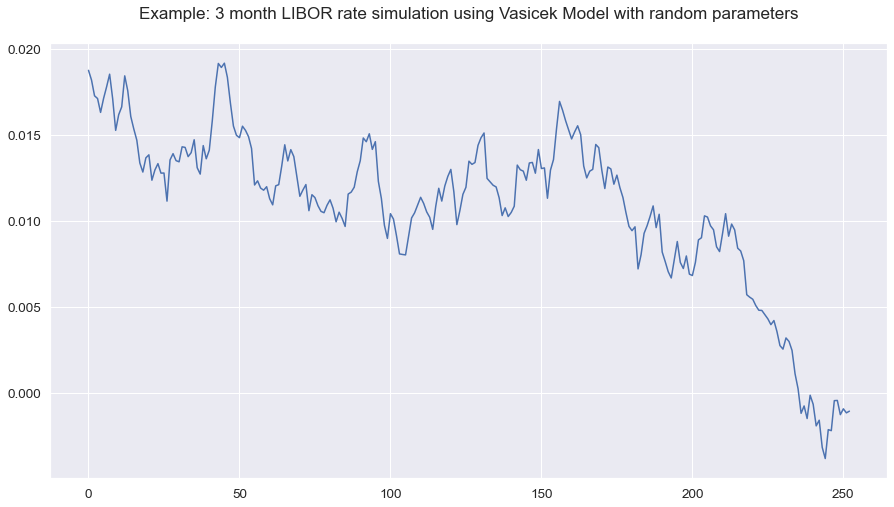

In [36]:
xo, yo = vasicek(0.01875, 0.20, -0.1, 0.001, 1, 252)

plt.title("Example: 3 month LIBOR rate simulation using Vasicek Model with random parameters")
plt.plot(xo,yo)
plt.show()

### MLE ESTIMATOR FOR LIBOR 

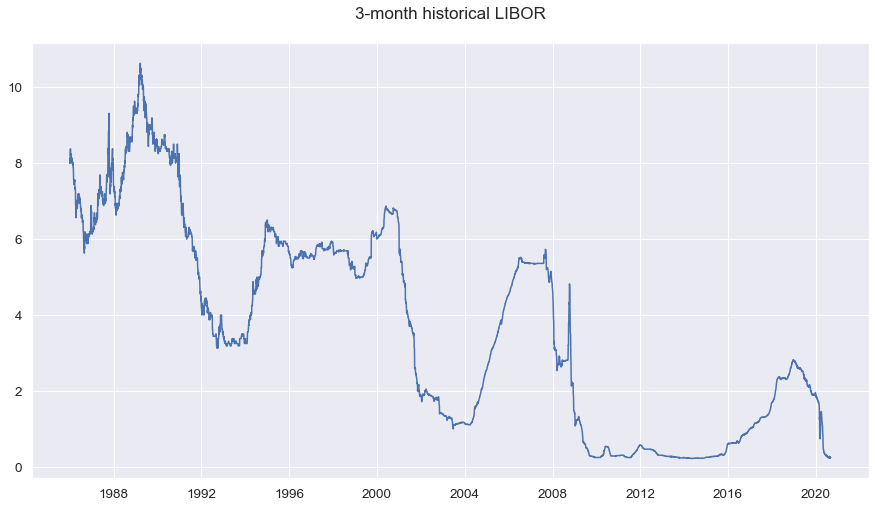

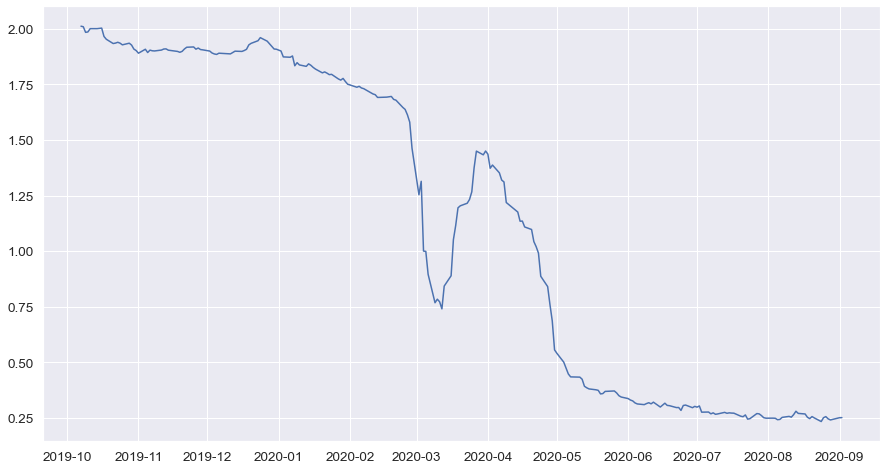

In [77]:
libor = pd.read_csv('3-month-libor.csv')
libor['Date'] = libor['Date'].astype('datetime64[ns]')
libor = libor.sort_values(by = ['Date'])
#df = df.drop(columns = ['Week day','ON','1W','1M','2M','6M','12M'])
#df.set_index('Date')
df = libor.iloc[-252:-22]

plt.title("3-month historical LIBOR")
plt.plot(libor['Date'], libor['3M'])
plt.show()
plt.plot(df['Date'], df['3M'])
plt.show()


In [90]:
df

,Date,3M
8530,2019-10-07,2.0120
8531,2019-10-08,2.0095
8532,2019-10-09,1.9843
8533,2019-10-10,1.9861
8534,2019-10-11,2.0009
...,...,...
8755,2020-08-26,0.2559
8756,2020-08-27,0.2460
8757,2020-08-28,0.2409
8758,2020-09-01,0.2511


In [94]:
r = np.array(df['3M'])
a = r[:len(r)-1]
r = r[1:]


x = np.array(df['3M'])
b = x[:len(x)-1]


In [95]:
s0 = (np.sum(r) - r[-1]) / len(r)
s1 = np.mean(r)
s00 = np.sum(a**2) / len(r)
s01 = np.sum(b*r) / len(r)
s0,s1,s00,s01

(1.131382096069869, 1.1324794759825327, 1.8020496173362446, 1.7925849102183407)

In [81]:
rn = (s1*s00 - s0*s01) / ((s0*s1) - (s0**2) + (s00-s01))
rn

1.1848889856883436

In [82]:
# dt value needs to be verified -- IMP IMP IMP

k = np.log((s0-np.mean(x)) / (s1 - np.mean(x)) ) / 3  # Taking dt = 3
k

0.08409727773057214

In [83]:
beta = 1/k * (1 - np.exp(k))
beta

-1.0432525688484389

In [84]:
def B(s):
    return (1 - np.exp(-k))/k

x = np.array(df['3M'])
u = np.mean(x)
m = np.array([])

for i in range(1,len(x)):
    a = (u * k * B(k)) + (x[i-1] * (1- (k * B(k)))) 
    m = np.append(m,a)


In [85]:
sig = 1/((len(x)*beta)*(1 - k*beta/2)) * np.sum((r - m)**2)
sig

-0.004275716012863767

In [99]:
df['3M'].iloc[-1], k, beta, sigma

(0.2513, 0.08409727773057214, -1.0432525688484389, 0.020456189051262293)

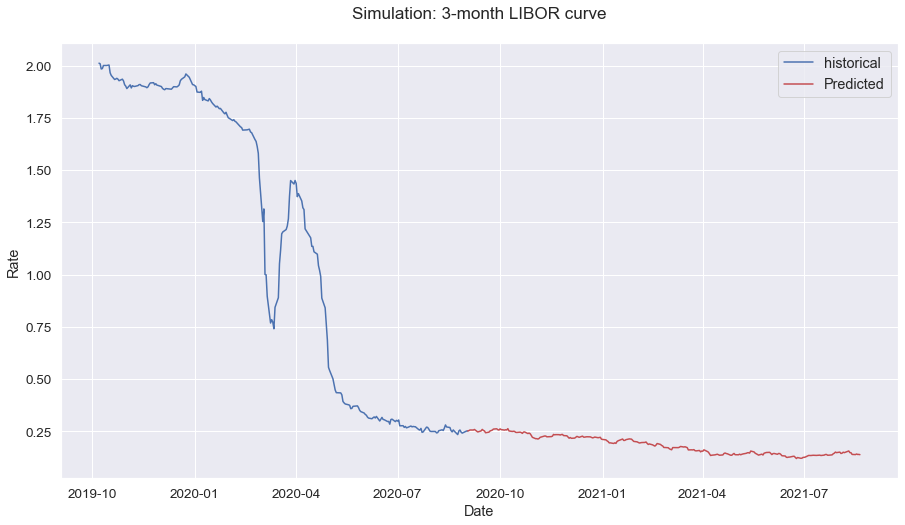

In [110]:
xo, yo = vasicek(df['3M'].iloc[-1], k, beta, sig, 1, 252)

rng = pd.date_range(df['Date'].iloc[-1], periods=253 , freq='B')
lib = pd.DataFrame({ 'Date': rng, '3M': yo}) 


plt.title('Simulation: 3-month LIBOR curve')
plt.plot(df['Date'], df['3M'], label = "historical")
plt.plot(lib['Date'], lib['3M'], color = 'r', label = "Predicted")
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()